## 输出总结果

In [226]:
import argparse
import json
import sys, os
import pandas as pd
import numpy as np

In [598]:
def get_summary(df, filter_error_hw=False):
    cmp_list = ["l1_hit_rate", "l1_hit_rate_g", "l1_hit_rate_ldg", "l1_hit_rate_stg", "l2_hit_rate", "l2_hit_rate_ld", "l2_hit_rate_st",
            "l2_ld_trans","l2_st_trans","l2_tot_trans","dram_ld_trans","dram_st_trans","dram_tot_trans",
            "gmem_tot_reqs", "gmem_ld_sectors", "gmem_st_sectors", "gmem_tot_sectors", "gmem_ld_diverg"]
    
    data = []
    for key in cmp_list:
        y1, y2 = df[f"{key}_hw"], df[f"{key}_sim"]

        if filter_error_hw:
            if "hit_rate" in key:
                valid_hw_res = y1 <= 1.01
                # print(y1.shape)
                shape1 = y1.shape
                y1 = y1[valid_hw_res]
                # print(y1.shape)
                shape2 = y1.shape
                if shape1 != shape2:
                    print(f"{key}: {shape1} -> {shape2}")
                y2 = y2[valid_hw_res]
        
        non_zero_idxs = y1 != 0
        MAPE = np.mean(np.abs(y1[non_zero_idxs] - y2[non_zero_idxs])/y1[non_zero_idxs])

        MAE = np.mean(np.abs(y1-y2))
        RMSE = np.sqrt(np.mean((y1 - y2)**2))
        NRMSE = np.sqrt(np.mean((y1 - y2)**2)) / np.mean(y1)
        corr = np.corrcoef(y1, y2)[0, 1]

        data.append({"MAPE": MAPE, "NRMSE": NRMSE, "Correlation": corr, 'MAE': MAE, 'RMSE':RMSE})
    df_summary = pd.DataFrame(data, index=cmp_list)
    return df_summary
def get_summary_by_bench(df, filter_error_hw=False):
    df_list = []
    keys = ["all"]
    df_list.append(get_summary(df, filter_error_hw=filter_error_hw))
    
    bench_groupby = df.groupby("bench", sort=False, as_index=False)
    for bench, group in bench_groupby:
        print(bench)
        df_list.append(get_summary(group, filter_error_hw=filter_error_hw))
        keys.append(bench)
    
    df_summary = pd.concat(df_list, keys=keys, axis=1)
    return df_summary

In [778]:
def print_compare_table(df_sim1, df_sim2, NRMSE=True, paper=False):
    cmp_list = {
        'gmem_tot_reqs': 'L1 Reqs',
        'gmem_tot_sectors': 'L1 Sectors',
        'l1_hit_rate': 'L1 Hit Rate',
        'l1_hit_rate_g': 'L1 Hit Rate Global',
        'l1_hit_rate_ldg': 'L1 Hit Rate Global Load',
        'l1_hit_rate_stg': 'L1 Hit Rate Global Store',
        'l2_ld_trans': 'L2 Reads',
        'l2_st_trans': 'L2 Writes',
        'l2_tot_trans': 'L2 Total Reqs',
        'l2_hit_rate': 'L2 Hit Rate',
        'l2_hit_rate_ld': 'L2 Read Hit Rate',
        'l2_hit_rate_st': 'L2 Write Hit Rate',
        'dram_ld_trans': 'DRAM Reads',
        'dram_st_trans': 'DRAM Writes',
        'dram_tot_trans': 'DRAM Total Reqs',
    }
    if paper:
        del cmp_list['gmem_tot_reqs']
        del cmp_list['gmem_tot_sectors']
        del cmp_list['l1_hit_rate_stg']
        del cmp_list['l2_hit_rate_st']
        NRMSE =False
    
    def to_percentage(x):
        return "{:.2%}".format(x)
    def round_2digt(x):
        return "{:.2f}".format(x)
    L = []
    if NRMSE:
        eval_metrics = ['MAPE', 'Correlation', 'NRMSE']
    else:
        eval_metrics = ['MAPE', 'Correlation']
    # eval_metrics = ['MAPE', 'Correlation', 'NRMSE', 'MAE', 'RMSE']
    for eval_metric in eval_metrics:
        if 'MAPE' == eval_metric:
            s1 = df_sim1[('all', eval_metric)].apply(to_percentage)
            s2 = df_sim2[('all', eval_metric)].apply(to_percentage)
        # elif 'Correlation'== eval_metric:
        elif True:
            s1 = df_sim1[('all', eval_metric)].apply(round_2digt)
            s2 = df_sim2[('all', eval_metric)].apply(round_2digt)
        else:
            s1 = df_sim1[('all', eval_metric)]
            s2 = df_sim2[('all', eval_metric)]
        L.append(s1)
        L.append(s2)
    merge_df = pd.concat(L, axis=1)
    merge_df.columns = pd.MultiIndex.from_product([eval_metrics, ['Old', 'New']])

    # rename metrics
    select_df = merge_df.loc[cmp_list.keys()].rename(index=cmp_list)
    return merge_df,select_df

### 读取 Excel

In [867]:
# sim_res = 'memory_ppt-gpu_CL128.xlsx'
# sim_res = 'memory_ppt-gpu_CL32.xlsx'
# sim_res2 = 'memory_simulator.xlsx'

# sim_res = 'memory_titanv_TITANV_ppt-gpu_base_CL32_34.xlsx'
# sim_res2 = 'memory_titanv_TITANV_simulator_base_34.xlsx'

# sim_res = 'memory_titanv_A100-40G_ppt-gpu_base_CL32_34.xlsx'
# sim_res2 = 'memory_titanv_A100-40G_simulator_base_34.xlsx'

sim_res = 'memory_titanv_TITANV_ppt-gpu_base_CL32.xlsx'
# sim_res = 'memory_titanv_TITANV_ppt-gpu_base_CL128.xlsx'
sim_res2 = 'memory_titanv_TITANV_simulator_base.xlsx'
# sim_res2 = 'memory_titanv_TITANV_simulator_no_flush_l2.xlsx'
# sim_res2 = 'memory_titanv_TITANV_simulator_fix_l2_write_hit_rate.xlsx'
# sim_res2 = 'memory_titanv_TITANV_sdcm_base.xlsx'
# sim_res2 = 'memory_titanv_TITANV_sdcmL1_base.xlsx'

# sim_res = 'xlsx_backup_2024_12_9/memory_titanv_TITANV_ppt-gpu_base_CL32.xlsx'
# # sim_res = 'memory_titanv_TITANV_ppt-gpu_base_CL128.xlsx'
# sim_res2 = 'xlsx_backup_2024_12_9/memory_titanv_TITANV_simulator_base.xlsx'

# # filter
sim_res = 'memory_titanv_TITANV_simulator_base.xlsx'
sim_res2 = 'memory_titanv_TITANV_simulator_nofilterl2.xlsx'
# sim_res2 = 'memory_titanv_TITANV_simulator_no_adaptive.xlsx'

# # sector
# sim_res = 'memory_titanv_TITANV_simulator_base.xlsx'
# # sim_res2 = 'memory_titanv_TITANV_simulator_l2_64CL_32S.xlsx'
# # sim_res2 = 'memory_titanv_TITANV_simulator_l2_64CL_64S.xlsx'
# sim_res2 = 'memory_titanv_TITANV_simulator_sector_l1_CL32.xlsx'
# # sim_res2 = 'memory_titanv_TITANV_simulator_sector_l1_CL128.xlsx'
# sim_res2 = 'memory_titanv_TITANV_simulator_sector_l2_CL32.xlsx'
# # sim_res2 = 'memory_titanv_TITANV_simulator_sector_l2_CL128.xlsx'

# ## ampere
# sim_res = 'memory_titanv_A100-40G_ppt-gpu_base_CL32.xlsx'
# sim_res2 = 'memory_titanv_A100-40G_simulator_base.xlsx'
# sim_res2 = 'memory_titanv_A100-40G_sdcmL1_base.xlsx'
# sim_res2 = 'memory_titanv_A100-40G_sdcm_base.xlsx'

# sim_res = 'memory_titanv_A100-40G_simulator_base.xlsx'
# sim_res2 = 'memory_titanv_A100-40G_simulator_ampere_l1_16A.xlsx'
# sim_res2 = 'memory_titanv_A100-40G_simulator_ampere_l1_64A.xlsx'
# sim_res2 = 'memory_titanv_A100-40G_simulator_ampere_l2_16A.xlsx'
# sim_res2 = 'memory_titanv_A100-40G_simulator_ampere_l2_64A.xlsx'

# sim_res = 'memory_a100-40g_A100-40G_ppt-gpu_base_CL32.xlsx'
# sim_res2 = 'memory_a100-40g_A100-40G_simulator_base.xlsx'

output_dir = 'paper_draw'

df_sim1 = pd.read_excel(sim_res, sheet_name="apps")
df_sim2 = pd.read_excel(sim_res2, sheet_name="apps")
# df_sim1 = pd.read_excel(sim_res, sheet_name="kernels")
# df_sim2 = pd.read_excel(sim_res2, sheet_name="kernels")
# print(df_sim1.columns)
# print(df_sim2['l2_hit_rate_st_hw'])
# print(df_sim2[df_sim2['l2_hit_rate_st_hw']<1.01].shape)
print(df_sim1.shape, df_sim2.shape)

(49, 39) (49, 39)


### 按照 yaml 重新选择应用

In [518]:
# %env app_yaml=/staff/fyyuan/repo/PPT-GPU-memory/memory_model/memory-apps.yml
# print(os.environ['app_yaml'])

sys.path.insert(0, "/staff/fyyuan/repo/PPT-GPU-memory/")
from scripts.common import parse_app_definition_yaml, get_suite_info, get_app_arg_list

app_yaml = "/staff/fyyuan/repo/PPT-GPU-memory/memory_model/memory-apps.yml"

In [868]:
defined_apps = parse_app_definition_yaml(app_yaml)
suite_info = get_suite_info(app_yaml)

apps = []
for suite in suite_info['suites']:
    apps += defined_apps[suite]
    
app_and_arg_list = get_app_arg_list(apps)
# print(app_and_arg_list[:3])

def filter_app(df):
    df = df[df['app'].isin(app_and_arg_list)]
    # print(df.index)
    return df
df_sim1 = filter_app(df_sim1)
df_sim2 = filter_app(df_sim2)
print(df_sim1.shape, df_sim2.shape)

(37, 39) (37, 39)


### 结果（过滤)

过滤掉命中率大于 1 的应用

In [809]:
df_summary1 = get_summary_by_bench(df_sim1, filter_error_hw=True)
df_summary2 = get_summary_by_bench(df_sim2, filter_error_hw=True)
# print(df_summary2)
_, select_df = print_compare_table(df_summary1, df_summary2, NRMSE=True)
select_df

l1_hit_rate_stg: (37,) -> (13,)
l2_hit_rate_st: (37,) -> (24,)
rodinia-3.1
l1_hit_rate_stg: (14,) -> (6,)
l2_hit_rate_st: (14,) -> (10,)
polybench
l1_hit_rate_stg: (9,) -> (2,)
Tango
l1_hit_rate_stg: (3,) -> (1,)
l2_hit_rate_st: (3,) -> (1,)
pannotia
l1_hit_rate_stg: (11,) -> (4,)
l2_hit_rate_st: (11,) -> (4,)
l1_hit_rate_stg: (37,) -> (13,)
l2_hit_rate_st: (37,) -> (24,)
rodinia-3.1
l1_hit_rate_stg: (14,) -> (6,)
l2_hit_rate_st: (14,) -> (10,)


/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2542080/3280751285.py:27: RuntimeWarning: invalid value encountered in scalar divide
  NRMSE = np.sqrt(np.mean((y1 - y2)**2)) / np.mean(y1)
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/staff/fyyuan/miniconda3/lib

polybench
l1_hit_rate_stg: (9,) -> (2,)
Tango
l1_hit_rate_stg: (3,) -> (1,)
l2_hit_rate_st: (3,) -> (1,)
pannotia
l1_hit_rate_stg: (11,) -> (4,)
l2_hit_rate_st: (11,) -> (4,)


/tmp/ipykernel_2542080/3280751285.py:27: RuntimeWarning: invalid value encountered in scalar divide
  NRMSE = np.sqrt(np.mean((y1 - y2)**2)) / np.mean(y1)
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


MAPE           Correlation       NRMSE        
                               Old       New         Old   New   Old     New
L1 Reqs                      6.44%     6.44%        1.00  1.00  0.05    0.05
L1 Sectors                   9.02%     9.02%        1.00  1.00  0.07    0.07
L1 Hit Rate                 11.07%    11.07%        0.99  0.99  0.10    0.10
L1 Hit Rate Global          11.18%    11.18%        0.99  0.99  0.10    0.10
L1 Hit Rate Global Load      7.35%     7.35%        1.00  1.00  0.06    0.06
L1 Hit Rate Global Store    41.73%    41.73%        0.84  0.84  0.83    0.83
L2 Reads                    12.01%   499.66%        0.95  0.84  1.33  102.33
L2 Writes                   11.63%    11.63%        1.00  1.00  0.06    0.06
L2 Total Reqs                9.05%   208.82%        1.00  0.85  0.18   17.42
L2 Hit Rate                 15.47%    37.75%        0.95  0.87  0.19    0.26
L2 Read Hit Rate            37.97%   147.68%        0.90  0.80  0.43    0.55
L2 Write Hit Rate            0.03%     0.03%         nan   nan  0.00    0.00
DRAM Reads                  14.09%    22.25%        1.00  0.99  0.16    0.28
DRAM Writes               1346.67%  1346.82%        0.99  0.99  0.36    0.36
DRAM Total Reqs             17.83%    24.80%        0.99  0.99  0.17    0.25

### 结果

In [796]:
df_summary1 = get_summary_by_bench(df_sim1, filter_error_hw=True)
df_summary2 = get_summary_by_bench(df_sim2, filter_error_hw=True)
# print(df_summary2)
_, select_df = print_compare_table(df_summary1, df_summary2, paper=True)
select_df

l1_hit_rate_stg: (37,) -> (13,)
l2_hit_rate_st: (37,) -> (24,)
rodinia-3.1
l1_hit_rate_stg: (14,) -> (6,)
l2_hit_rate_st: (14,) -> (10,)
polybench
l1_hit_rate_stg: (9,) -> (2,)
Tango
l1_hit_rate_stg: (3,) -> (1,)
l2_hit_rate_st: (3,) -> (1,)
pannotia
l1_hit_rate_stg: (11,) -> (4,)
l2_hit_rate_st: (11,) -> (4,)
l1_hit_rate_stg: (37,) -> (13,)
l2_hit_rate_st: (37,) -> (24,)


/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2542080/3280751285.py:27: RuntimeWarning: invalid value encountered in scalar divide
  NRMSE = np.sqrt(np.mean((y1 - y2)**2)) / np.mean(y1)
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/staff/fyyuan/miniconda3/lib

rodinia-3.1
l1_hit_rate_stg: (14,) -> (6,)
l2_hit_rate_st: (14,) -> (10,)
polybench
l1_hit_rate_stg: (9,) -> (2,)
Tango
l1_hit_rate_stg: (3,) -> (1,)
l2_hit_rate_st: (3,) -> (1,)
pannotia
l1_hit_rate_stg: (11,) -> (4,)
l2_hit_rate_st: (11,) -> (4,)


/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_2542080/3280751285.py:27: RuntimeWarning: invalid value encountered in scalar divide
  NRMSE = np.sqrt(np.mean((y1 - y2)**2)) / np.mean(y1)
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


MAPE           Correlation      
                              Old       New         Old   New
L1 Hit Rate                11.07%    11.07%        0.99  0.99
L1 Hit Rate Global         11.18%    11.18%        0.99  0.99
L1 Hit Rate Global Load     7.35%     7.35%        1.00  1.00
L2 Reads                   12.01%   499.66%        0.95  0.84
L2 Writes                  11.63%    11.63%        1.00  1.00
L2 Total Reqs               9.05%   208.82%        1.00  0.85
L2 Hit Rate                15.47%    37.75%        0.95  0.87
L2 Read Hit Rate           37.97%   147.68%        0.90  0.80
DRAM Reads                 14.09%    22.25%        1.00  0.99
DRAM Writes              1346.67%  1346.82%        0.99  0.99
DRAM Total Reqs            17.83%    24.80%        0.99  0.99

### 直接读取 summary 打印结果

In [435]:
df_summary1 = pd.read_excel(sim_res, sheet_name="apps_summary", header=[0, 1], index_col=0)
df_summary2 = pd.read_excel(sim_res2, sheet_name="apps_summary", header=[0, 1], index_col=0)
# df_summary1 = pd.read_excel(sim_res, sheet_name="kernels_summary", header=[0, 1], index_col=0)
# df_summary2 = pd.read_excel(sim_res2, sheet_name="kernels_summary", header=[0, 1], index_col=0)
# print(df_summary2)
_, select_df = print_compare_table(df_summary1, df_summary2, NRMSE=True)

In [436]:
select_df

,MAE,,Correlation,,NRMSE,
,Old Model,New Model,Old Model,New Model,Old Model,New Model
L1 Reqs,8.83%,3.94%,99.99%,100.00%,41.19%,2.31%
L1 Sectors,14.45%,9.21%,99.99%,100.00%,51.15%,1.47%
L1 Hit Rate,14.65%,12.48%,99.29%,99.30%,8.22%,8.34%
L1 Hit Rate Global,14.63%,12.48%,99.29%,99.30%,8.23%,8.34%
L1 Hit Rate Global Load,12.26%,8.84%,99.63%,99.72%,6.16%,5.30%
L2 Reads,27.21%,27.23%,97.22%,99.21%,128.20%,29.80%
L2 Writes,55.59%,56.70%,99.52%,99.37%,94.59%,124.45%
L2 Total Reqs,36.85%,38.43%,99.58%,99.48%,67.89%,106.32%
L2 Hit Rate,42.83%,29.17%,2.89%,35.33%,56.51%,48.12%


### 获取 app 信息

In [619]:
# sys.path.insert(0, "/staff/fyyuan/repo/PPT-GPU-memory/")
%load_ext autoreload
%autoreload 2
from scripts.common import parse_app_definition_yaml, get_suite_info, get_app_arg_list

import inspect
# print(inspect.getsource(get_suite_info))

app_yaml = "/staff/fyyuan/repo/PPT-GPU-memory/memory_model/memory-apps.yml"
# defined_apps = parse_app_definition_yaml(app_yaml)
suite_info = get_suite_info(app_yaml)

sim_res = 'memory_titanv_TITANV_ppt-gpu_base_CL32.xlsx'
df_kernels = pd.read_excel(sim_res, sheet_name="kernels")
df_kernels = filter_app(df_kernels)
df_apps = df_kernels.groupby('app', as_index=False, sort=False).size()
df_apps.rename(columns={'size': 'Kernels'}, inplace=True)
# df_apps

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,app,Kernels
0,b+tree-rodinia-3.1/file___data_mil_txt_command...,2
1,backprop-rodinia-3.1/65536,2
2,bfs-rodinia-3.1/__data_graph4096_txt,16
3,cfd-rodinia-3.1/__data_fvcorr_domn_097K,24
4,dwt2d-rodinia-3.1/__data_rgb_bmp__d_1024x1024_...,10
5,gaussian-rodinia-3.1/_s_16,30
6,gaussian-rodinia-3.1/_s_64,126
7,hotspot-rodinia-3.1/1024_2_2___data_temp_1024_...,1
8,lavaMD-rodinia-3.1/_boxes1d_10,1
9,nn-rodinia-3.1/__data_filelist_4__r_5__lat_30_...,1


In [642]:
import subprocess

def get_dir_size(path, get_logic=True):
    if get_logic:
        cmd = f'du --apparent-size {path}'
    else:
        cmd = f"du {path}"
    res = subprocess.run(cmd, shell=True, capture_output=True)
    size = res.stdout.decode().split('\t')[0]
    # print(cmd)
    # print(res.stdout.decode())
    # exit(1)
    return int(size)*1024
    
# print(df_sim1['app'])
# 统计应用 Trace 大小，运行实例数目
bench_info = {
    'abbr': [],
    'trace_size': [],
}
for app_arg in df_apps['app']:
    abbr = suite_info['map'][app_arg][-1]
    print(f"{abbr}: {app_arg}")
    bench_info['abbr'].append(abbr)

    trace_dir = '/staff/fyyuan/hw_trace01/ppt-gpu-titanv/11.0'
    app_memory_trace_dir = os.path.join(trace_dir, app_arg, 'memory_traces')
    # dir_size = 1
    dir_size = get_dir_size(app_memory_trace_dir)
    # print(dir_size)
    bench_info['trace_size'].append(dir_size)
df_bench_info = pd.concat([df_apps, pd.DataFrame(bench_info)], axis=1)
df_bench_info

BTREE: b+tree-rodinia-3.1/file___data_mil_txt_command___data_command_txt
BP: backprop-rodinia-3.1/65536
BFS: bfs-rodinia-3.1/__data_graph4096_txt
CFD: cfd-rodinia-3.1/__data_fvcorr_domn_097K
DWT2D: dwt2d-rodinia-3.1/__data_rgb_bmp__d_1024x1024__f__5__l_3
GS: gaussian-rodinia-3.1/_s_16
GS: gaussian-rodinia-3.1/_s_64
HS: hotspot-rodinia-3.1/1024_2_2___data_temp_1024___data_power_1024_output_out
LMD: lavaMD-rodinia-3.1/_boxes1d_10
NN: nn-rodinia-3.1/__data_filelist_4__r_5__lat_30__lng_90
NW: nw-rodinia-3.1/2048_10
PF: pathfinder-rodinia-3.1/100000_100_20___result_txt
SRAD: srad_v1-rodinia-3.1/100_0_5_502_458
SC: streamcluster-rodinia-3.1/3_6_16_65536_65536_1000_none_output_txt_1_output_txt
2MM: polybench-2mm/NO_ARGS
3MM: polybench-3mm/NO_ARGS
BICG: polybench-bicg/NO_ARGS
GEMM: polybench-gemm/NO_ARGS
GEMVER: polybench-gemver/NO_ARGS
GESUMMV: polybench-gesummv/NO_ARGS
SYRK: polybench-syrk/NO_ARGS
2DCONV: polybench-convolution2D/NO_ARGS
JACOBI2D: polybench-jacobi2D/NO_ARGS
AN: AN/1
GRU: GRU/

,app,Kernels,abbr,trace_size
0,b+tree-rodinia-3.1/file___data_mil_txt_command...,2,BTREE,753604608
1,backprop-rodinia-3.1/65536,2,BP,168092672
2,bfs-rodinia-3.1/__data_graph4096_txt,16,BFS,3971072
3,cfd-rodinia-3.1/__data_fvcorr_domn_097K,24,CFD,764519424
4,dwt2d-rodinia-3.1/__data_rgb_bmp__d_1024x1024_...,10,DWT2D,181318656
5,gaussian-rodinia-3.1/_s_16,30,GS,86016
6,gaussian-rodinia-3.1/_s_64,126,GS,4879360
7,hotspot-rodinia-3.1/1024_2_2___data_temp_1024_...,1,HS,64565248
8,lavaMD-rodinia-3.1/_boxes1d_10,1,LMD,498594816
9,nn-rodinia-3.1/__data_filelist_4__r_5__lat_30_...,1,NN,1712128


In [661]:
g = df_bench_info.groupby('abbr', as_index=False, sort=False)

df_bench_info2 = g.sum()
df_bench_info2

def bytes_to_human(x):
    G, M, K = 2**30, 2**20, 2**10
    if x >= G:
        return f'{x/G:.0f}GB'
    elif x >= M:
        return f'{x/M:.0f}MB'
    else:
        return f'{x/K:.0f}KB'
        
print(f'total: {df_bench_info2["trace_size"].sum()//2**30:.2f}GB')
print(f'total Kernels: {df_bench_info2["Kernels"].sum()}')
df_bench_info2['Trace size'] = df_bench_info2['trace_size'].apply(bytes_to_human)
df_bench_info2.drop(columns=['app'], inplace=True)
df_bench_info3 = df_bench_info2
df_bench_info3['Instance'] = g.size()['size']
df_bench_info3.reindex(columns=['abbr','Instance', 'Kernels', 'Trace size'])

total: 196.00GB
total Kernels: 1736


,abbr,Instance,Kernels,Trace size
0,BTREE,1,2,719MB
1,BP,1,2,160MB
2,BFS,1,16,4MB
3,CFD,1,24,729MB
4,DWT2D,1,10,173MB
5,GS,2,156,5MB
6,HS,1,1,62MB
7,LMD,1,1,475MB
8,NN,1,1,2MB
9,NW,1,255,120MB


### 删除部分应用（obseleted）

In [509]:
# del app
def del_app(df):
    indexes_to_drop = df[df['app'].isin(
        ['bfs-rodinia-3.1/__data_graph65536_txt', 'bfs-rodinia-3.1/__data_graph1MW_6_txt', 'dwt2d-rodinia-3.1/__data_192_bmp__d_192x192__f__5__l_3',
         'gaussian-rodinia-3.1/_f___data_matrix4_txt', 'gaussian-rodinia-3.1/_s_16', 'gaussian-rodinia-3.1/_s_64',
         'lavaMD-rodinia-3.1/_boxes1d_10', 'polybench-atax/NO_ARGS', 'polybench-mvt/NO_ARGS', 
        ]
    )].index
    df.drop(indexes_to_drop, inplace=True)

del_app(df_sim1)
del_app(df_sim2)

## 按 metric 对比

In [512]:
def get_MAPE(df):
    MAPE = (df[f'{metric}_sim'] - df[f'{metric}_hw']) / df[f'{metric}_hw']
    MAPE.name = metric
    MAPE.index = df['app']
    return MAPE
def get_corr(df):
    y1, y2 = df[f'{metric}_sim'], df[f'{metric}_hw']
    corr = np.corrcoef(y1, y2)[0, 1]
    return corr

In [513]:
sim_res = 'memory_titanv_TITANV_ppt-gpu_base_CL32.xlsx'
# sim_res = 'memory_titanv_TITANV_ppt-gpu_base_CL128.xlsx'
sim_res2 = 'memory_titanv_TITANV_simulator_base.xlsx'
metric = 'l2_ld_trans'

df_sim1 = pd.read_excel(sim_res, sheet_name="apps")
df_sim2 = pd.read_excel(sim_res2, sheet_name="apps")
print(df_sim1.shape, df_sim2.shape)
print(f'corr: {get_corr(df_sim1)}, {get_corr(df_sim2)}')

(49, 39) (49, 39)
ppt-gpu: 0.9312200647049099, my: 0.8965355438425157


In [514]:
MAPE1=get_MAPE(df_sim1)
MAPE2=get_MAPE(df_sim2)
df = pd.concat([MAPE1, MAPE2], axis=1)
print(df.mean())
print(df.abs().mean())
df

l2_ld_trans    0.183974
l2_ld_trans   -0.000940
dtype: float64
l2_ld_trans    0.307949
l2_ld_trans    0.193077
dtype: float64


,l2_ld_trans,l2_ld_trans
app,,
b+tree-rodinia-3.1/file___data_mil_txt_command___data_command_txt,0.410911,0.234647
backprop-rodinia-3.1/65536,0.478186,0.017342
bfs-rodinia-3.1/__data_graph4096_txt,0.249143,-0.077188
bfs-rodinia-3.1/__data_graph65536_txt,0.234460,0.285207
bfs-rodinia-3.1/__data_graph1MW_6_txt,0.256138,0.448536
cfd-rodinia-3.1/__data_fvcorr_domn_097K,0.079711,0.088543
dwt2d-rodinia-3.1/__data_192_bmp__d_192x192__f__5__l_3,-0.032601,-0.032401
dwt2d-rodinia-3.1/__data_rgb_bmp__d_1024x1024__f__5__l_3,0.027022,0.001447
gaussian-rodinia-3.1/_f___data_matrix4_txt,-0.849558,-0.849558


## 画图

In [544]:
from scripts.common import get_suite_info

In [881]:
def get_metric_df(df_sim1, df_sim2, metric):
    df1 = df_sim1[['app', f"{metric}_sim"]]
    df2 = df_sim2[[f"{metric}_sim", f"{metric}_hw"]]
    df_new = pd.concat([df1, df2], axis=1)
    
    # rename columns
    df_new.columns = ['APP', 'PPT-GPU', 'Ours', 'HW']

    app_rename_map = {}
    for app in df_new['APP']:
        abbr = suite_info['map'][app][-1]
        app_rename_map[app] = abbr
    df_new['APP'] = df_new['APP'].map(app_rename_map)
    df_new = df_new.set_index('APP')
    return df_new

def draw_bar(df_sim1, df_sim2, draw_list):
    for metric in draw_list:
        print(f"Drawing {metric}...")
        df_metric = get_metric_df(df_sim1, df_sim2, metric)

        # df_metric.plot.bar()
        # save to excel
        with pd.ExcelWriter(os.path.join(output_dir, f"{metric}.xlsx"), engine='xlsxwriter') as writer:
            df_new.to_excel(writer, sheet_name=metric, index=False)

### 读取文件过滤

In [951]:
sim_res = 'memory_titanv_TITANV_ppt-gpu_base_CL32.xlsx'
sim_res2 = 'memory_titanv_TITANV_simulator_base.xlsx'
# sim_res = 'memory_titanv_A100-40G_ppt-gpu_base_CL32.xlsx'
# sim_res2 = 'memory_titanv_A100-40G_simulator_base.xlsx'

# sim_res = 'memory_titanv_TITANV_simulator_base.xlsx'
# sim_res2 = 'memory_titanv_TITANV_simulator_nofilterl2.xlsx'


df_sim1 = pd.read_excel(sim_res, sheet_name="apps")
df_sim2 = pd.read_excel(sim_res2, sheet_name="apps")
# df_sim1 = pd.read_excel(sim_res, sheet_name="kernels")
# df_sim2 = pd.read_excel(sim_res2, sheet_name="kernels")

df_sim1 = filter_app(df_sim1)
df_sim2 = filter_app(df_sim2)
print(df_sim1.shape, df_sim2.shape)

(37, 39) (37, 39)


### 条形图对比

In [870]:
# df1 = get_metric_df(df_sim1, df_sim2, 'dram_ld_trans')
df1 = get_metric_df(df_sim1, df_sim2, 'l2_hit_rate_ld')
df2 = get_metric_df(df_sim1, df_sim2, 'l2_hit_rate')
# df2 = get_metric_df(df_sim1, df_sim2, 'dram_st_trans')
# df3 = get_metric_df(df_sim1, df_sim2, 'dram_tot_trans')

<Axes: xlabel='APP'>

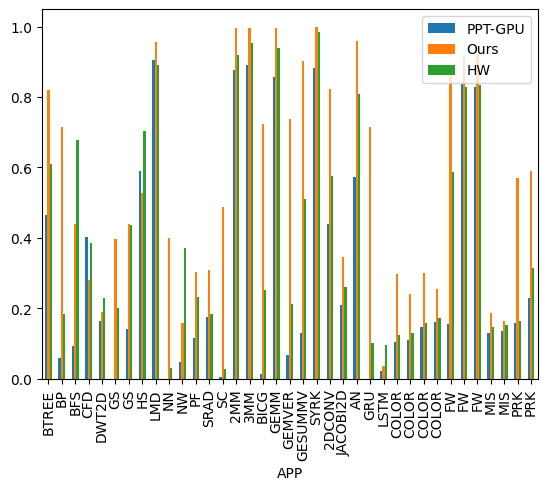

In [871]:
df1.plot.bar()

In [ ]:
# pd.DataFrame({'ld': df1, 'st': df2, 'tot': df3})

In [822]:
def get_MAPE(df):
    df2 = (df['PPT-GPU'] - df['HW'])/df['HW']
    df3 = (df['Ours'] - df['HW'])/df['HW']
    df4 = pd.concat([df2, df3], axis=1)
    return df4
def get_big(df):
    df2 = (df['PPT-GPU'] > df['HW'])
    df3 = (df['Ours'] > df['HW'])
    df4 = pd.concat([df2, df3], axis=1)
    return df4

In [827]:
BIG = get_big(df2).sum()
BIG

0    32
1     6
dtype: int64

In [821]:
MAPE = get_MAPE(df2)
print(MAPE.mean())
print(MAPE.abs().mean())
MAPE

0    0.300894
1   -0.144139
dtype: float64
0    0.377539
1    0.154662
dtype: float64


,0,1
APP,,
BTREE,0.274403,-0.196692
BP,0.129506,-0.094043
BFS,-0.232655,-0.322297
CFD,0.030969,0.002503
DWT2D,0.060879,0.036962
GS,0.336845,0.136393
GS,0.061712,-0.037549
HS,-0.118215,-0.121502
LMD,0.028696,0.013729


<Axes: xlabel='APP'>

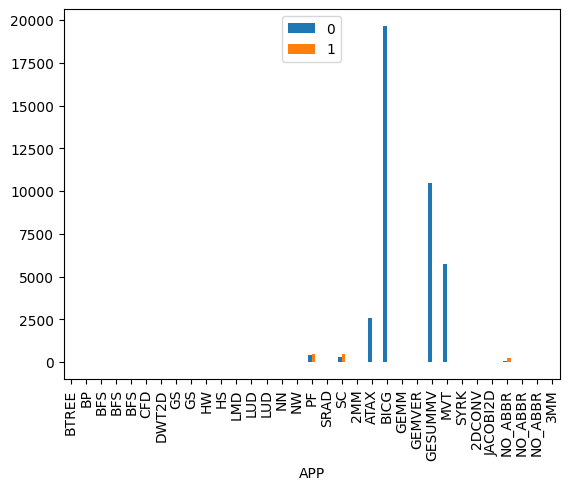

In [159]:
df4.plot.bar()

<Axes: xlabel='APP'>

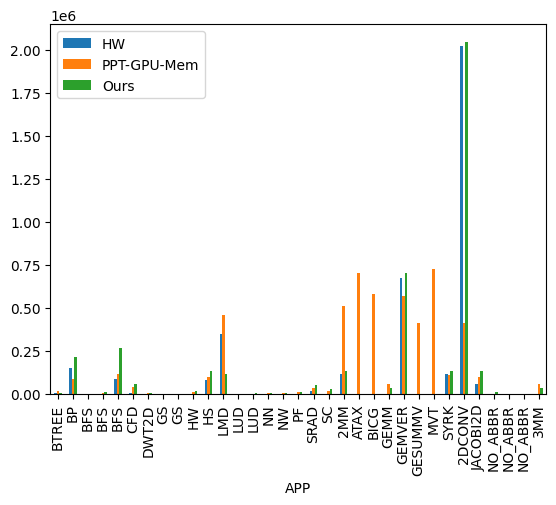

In [160]:
df.plot.bar()

### Corrleation

In [1022]:
import json

from matplotlib import pyplot as plt
import pandas as pd

def plot_sub(fig, ax, df, stat, log=False, log_x_min=-1, legend=True):
    y1, y2, y3 = df['PPT-GPU'], df['Ours'], df['HW']
    
    # 绘制散点图
    ax.scatter(y3, y2, color=(1, 0.2, 0.2, 0.5), s=50, marker='o', label='Ours vs HW')  # 蓝色，透明
    ax.scatter(y3, y1, color=(0.2, 0.6, 1, 0.5), s=50, marker='^', label='PPT-GPU vs HW')  # 红色，透明
    if legend:
        ax.legend()

    # 计算范围
    min_val = min(min(y1.min(), y2.min()), y3.min())
    max_val = max(y1.max(), y2.max(), y3.max())
    # min_val -= 0.1 * (max_val - min_val)
    max_val *= 1.1

    # 绘制参考线
    ax.plot([min_val, max_val], [min_val, max_val],
            color='black', linestyle='--', linewidth=1, alpha=0.7)

    # 设置对数坐标轴
    if log:
        ax.set_xscale('log')
        ax.set_yscale('log')

        print(min_val, max_val)
        if log_x_min!=-1:
            ax.set_xlim(log_x_min, max_val)
            ax.set_ylim(log_x_min, max_val)
        else:
            ax.set_xlim(max(min_val, 1), max_val)
            ax.set_ylim(max(min_val, 1), max_val)
        
        # # 计算对数范围
        # log_min = np.log10(min_val)
        # log_max = np.log10(max_val)
        
        # # 设置一致的对数坐标范围
        # ax.set_xlim(10**log_min, 10**log_max)
        # ax.set_ylim(10**log_min, 10**log_max)
    else:
        ax.set_xlim(min_val, max_val)
        ax.set_ylim(min_val, max_val)

    # 美化边框
    # ax.spines['top'].set_visible(False)   # 隐藏顶部边框
    # ax.spines['right'].set_visible(False) # 隐藏右侧边框
    # ax.spines['left'].set_linewidth(1.5)  # 设置左侧边框线宽
    # ax.spines['bottom'].set_linewidth(1.5) # 设置底部边框线宽

    # 设置刻度样式
    # ax.tick_params(axis='both', which='major', direction='in', length=6, width=1.5, labelsize=12)
    # ax.tick_params(axis='both', which='minor', direction='in', length=3, width=1)

    # 设置坐标轴标签字体为 Times New Roman
    font = {
            # 'fontname': 'Times New Roman',
            # 'fontsize': 12
        }
    ax.set_xlabel(f"HW {stat}", **font)
    ax.set_ylabel(f"Sim {stat}", **font)

    # 设置相等比例
    ax.set_aspect('equal', adjustable='box')

def draw_correl2(df1, df2, save_img, stat, log=False, log_x_min=-1, save_pdf='output.pdf', updown=False):
    if updown:
        fig, axes = plt.subplots(2, 1, figsize=(8, 8))  # 设置画布大小
    else:
        fig, axes = plt.subplots(1, 2)  # 设置画布大小
    plot_sub(fig, axes[0], df1, stat[0])
    plot_sub(fig, axes[1], df2, stat[1])

    plt.tight_layout()
    # 保存图片
    fig.savefig(save_img, dpi=300, bbox_inches='tight')  # 高分辨率保存
    fig.savefig(save_pdf, format='pdf', bbox_inches='tight')
    plt.show()
    plt.close(fig)

def draw_correl3(df1, df2, df3, save_img, stat, log=False, log_x_min=-1, save_pdf='output.pdf', updown=False, figsize=(9, 4)):
    fig, axes = plt.subplots(1, 3, figsize=figsize)  # 设置画布大小
    plot_sub(fig, axes[0], df1, stat[0])
    plot_sub(fig, axes[1], df2, stat[1], legend=False)
    plot_sub(fig, axes[2], df3, stat[2], legend=False)

    plt.tight_layout()
    # 保存图片
    fig.savefig(save_img, dpi=300, bbox_inches='tight')  # 高分辨率保存
    fig.savefig(save_pdf, format='pdf', bbox_inches='tight')
    plt.show()
    plt.close(fig)
    
def draw_correl(df, save_img, stat, log=False, log_x_min=-1, save_pdf='output.pdf'):
    fig, ax = plt.subplots(figsize=(4, 4))
    
    plot_sub(fig, ax, df, stat, log, log_x_min)
    # 保存图片
    fig.savefig(save_img, dpi=300, bbox_inches='tight')  # 高分辨率保存
    fig.savefig(save_pdf, format='pdf', bbox_inches='tight')
    plt.show()
    plt.close(fig)


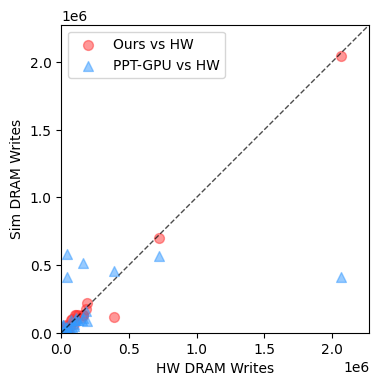

In [996]:
## df1 = get_metric_df(df_sim1, df_sim2, 'dram_st_trans')
# df1
# df1.to_excel('tmp.xlsx')
# df2 = pd.read_excel('tmp.xlsx')
# df2
# df2 = pd.read_excel('tmp.xlsx')
draw_correl(df1, 'tmp_draw/corrl.png', 'DRAM Writes', log=False, save_pdf='DRAM_writes.pdf')
# draw_correl(df1, 'tmp_draw/corrl.png', 'DRAM Writes', log=True)
# draw_correl(df1, 'tmp_draw/corrl.png', 'DRAM Writes', log=True, log_x_min=10, save_pdf='DRAM_writes.pdf')

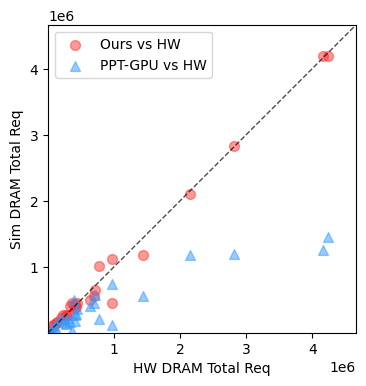

In [997]:
df2 = get_metric_df(df_sim1, df_sim2, 'dram_tot_trans')
draw_correl(df2, 'tmp_draw/corrl_dram_tot.png', 'DRAM Total Req', log=False, save_pdf='DRAM_tot.pdf')
# draw_correl(df2, 'tmp_draw/corrl_dram_tot.png', 'DRAM Total Reqs', log=True, log_x_min=100)

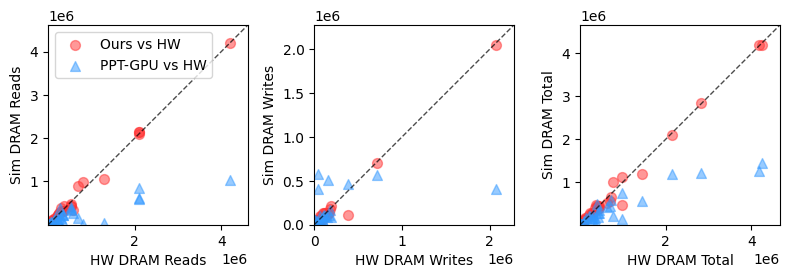

In [1023]:
df3 = get_metric_df(df_sim1, df_sim2, 'dram_ld_trans')
# draw_correl2(df1, df2, 'tmp_draw/corrl_dram.png', ['DRAM Writes', 'DRAM Total Req'], log=False, save_pdf='DRAM.pdf')
draw_correl3(df3, df1, df2, 'tmp_draw/corrl_dram.png', ['DRAM Reads', 'DRAM Writes', 'DRAM Total'], log=False, save_pdf='DRAM2.pdf', figsize=(8, 4))


### L2 CSDD

In [1106]:
def draw_csdd(csdd1, csdd2, img_path):
    import matplotlib.pyplot as plt
    
    x1 = [sd for sd, _ in csdd1]
    y1 = [accum for _, accum in csdd1]
    x2 = [sd for sd, _ in csdd2]
    y2 = [accum for _, accum in csdd2]
    
    fig, ax = plt.subplots()

    ax.plot(x1, y1, label='No Filter')
    ax.plot(x2, y2, label='Filter')
    ax.legend()

    ax.set_ylim(0, 1)
    
    # add some text for labels, title and axes ticks
    ax.set_xlabel("Stack Distance")
    ax.set_ylabel("CSDD")
    fig.savefig(img_path)
    plt.show()
    plt.close(fig)

def draw_csdd_list1(csdd_list, labels, img_path, save_pdf='output.pdf'):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()

    for i,csdd in enumerate(csdd_list):
        x1 = [sd for sd, _ in csdd]
        y1 = [accum for _, accum in csdd]
        ax.plot(x1[:-1], y1[:-1], label=labels[i])
    
    ax.legend()
    ax.set_ylim(0, 1)
    
    # add some text for labels, title and axes ticks
    ax.set_xlabel("Stack Distance")
    ax.set_ylabel("CSDD")
    fig.savefig(img_path)
    fig.savefig(save_pdf, format='pdf', bbox_inches='tight')
    plt.show()
    plt.close(fig)

def draw_csdd_list(csdd_list, labels, img_path, save_pdf='output.pdf', figsize=(8, 6)):
    import matplotlib.pyplot as plt
    import seaborn as sns

    # 设置风格和背景
    sns.set_theme(style="whitegrid")

    fig, ax = plt.subplots(figsize=figsize)

    # 定义不同的线条样式和标记点样式
    # line_styles = ['-', '--', '-.', ':']  # 实线、虚线、点划线、点线
    # colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']
    # plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#ADD8E6', '#90EE90', '#FFB6C1', '#FFA07A'])
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    colors = [
        '#4f80bc',  # 蓝
        '#9aba59',  # 绿
        '#bf504d',  # 红
        
        # # '#1f77b4',  # 蓝色
        # '#98cbff',  # 蓝色
        # # '#ff7f0e',  # 橙色
        # '#2ca02c',  # 绿色
        # # '#d62728',  # 红色
        # '#ff9898',  # 红色（淡）
        
        '#9467bd',  # 紫色
        '#8c564b',  # 棕色
        '#e377c2',  # 粉色
        '#7f7f7f',  # 灰色
        '#bcbd22',  # 黄绿色
        '#17becf',  # 蓝绿色
    ]
    line_styles = ['-', '--']  # 实线、虚线、点划线、点线
    markers = ['o', 's', 'D', '^']  # 圆点、方块、菱形、三角形
    pair_list = list(zip(line_styles, markers))

    for i, csdd in enumerate(csdd_list):
        x1 = [sd for sd, _ in csdd]
        y1 = [accum for _, accum in csdd]
        ax.plot(
            x1[:-1], 
            y1[:-1], 
            linestyle=line_styles[i % len(line_styles)],  # 轮换线条样式
            marker=markers[(i//2) % len(markers)],  # 轮换标记样式
            color=colors[(i//2)%len(colors)],
            label=labels[i], 
            linewidth=1.5, 
            markevery=int(len(x1)/20),
            markersize=6  # 标记点大小
        )
    
    # 设置图例
    ax.legend(
        loc="lower right",
        frameon=True,
        fontsize=12,
        shadow=True
    )

    # 设置轴范围
    ax.set_ylim(0, 1)
    ax.set_xlim(0)

    # 设置轴标签和标题
    ax.set_xlabel("Stack Distance", fontsize=14, labelpad=10)
    ax.set_ylabel("CSDD", fontsize=14, labelpad=10)
    # ax.set_title("CSDD vs Stack Distance", fontsize=16, pad=15)

    # 美化刻度
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True, linestyle="--", alpha=0.6)

    # 保存图表
    fig.tight_layout()
    fig.savefig(img_path, dpi=300, bbox_inches='tight')
    fig.savefig(save_pdf, format='pdf', bbox_inches='tight')
    plt.show()
    plt.close(fig)


In [1053]:
from src.sdcm import get_stack_distance, get_sdd_dict, get_csdd, draw_SD, draw_sdd, draw_csdd

def get_(l1_dump_trace):
    with open(l1_dump_trace) as f:
        smi_trace_ = json.load(f)
    smi_trace = smi_trace_
    from src.sdcm import get_stack_distance, get_sdd_dict, get_csdd, draw_SD, draw_sdd, draw_csdd
    SD = get_stack_distance(smi_trace)
    # sdd_dict = get_sdd_dict(SD, smi_trace)
    # print(sdd_dict)
    sdd, csdd = get_csdd(SD)
    label = l1_dump_trace.replace('.json', '')
    outptu_dir = 'paper_draw'
    debug_save = {'SD': SD, 'sdd': sdd, 'csdd': csdd}
    with open(f"{label}_debug.json", 'w') as f:
        json.dump(debug_save, f)
    return debug_save

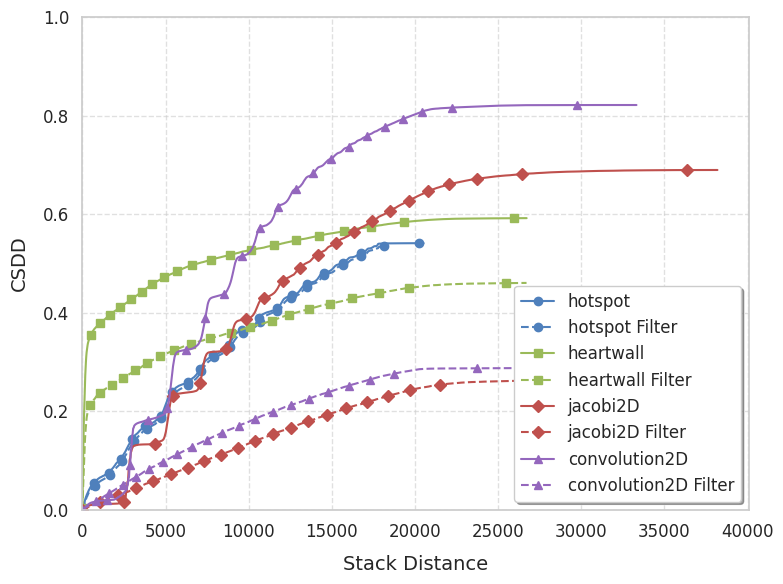

In [1115]:
# apps = ['cfd', 'convolution2D']
apps = ['hotspot', 'heartwall','jacobi2D', 'convolution2D']
# apps = ['jacobi2D']
csdd_list = []
labels = []
for app in apps:
    debug1_json = f'l2_dump_trace_{app}_debug.json'
    debug2_json = f'l2_dump_trace_{app}_L1_Filter_debug.json'
    try:
        with open(debug1_json) as f:
            debug1_save = json.load(f)
    except:
        l2_dump_trace = f'l2_dump_trace_{app}.json'
        debug1_save = get_(l2_dump_trace)
    try:
        with open(debug2_json) as f:
            debug2_save = json.load(f)
    except:
        l2_dump_trace = f'l2_dump_trace_{app}_L1_Filter.json'
        debug2_save = get_(l2_dump_trace)
    csdd_list += [debug1_save['csdd'], debug2_save['csdd']]
    labels += [f'{app}', f'{app} Filter']

draw_csdd_list(csdd_list, labels, 'test.png', save_pdf='csdd.pdf')


## 其它

### L1 Cache size

In [842]:
def json2df(json_data):
    '''
    list of dict 形式
    '''
    data = []
    for app_arg, app_res in json_data.items():
        # bench = suite_info['map'][app_arg][0]
        # print(app_arg, app_res)
        if app_arg == '0':
            continue
        for i, kernel_res in enumerate(app_res):
            # kernel_res['bench'] = bench
            kernel_res['app'] = app_arg
            kernel_res['kernel_id'] = kernel_res['kernel_name']
            data.append(kernel_res)
    return pd.DataFrame(data, columns=["app", "kernel_id"] + ['l1_cache_size'])


In [858]:
json_path = 'tmp/res_memory_titanv_11.0_TITANV_paper6_simulator_base.json'

with open(json_path) as f:
    sim_res = json.load(f)

df_sim1  = json2df(sim_res)
# df_sim1 = df_sim1.groupby(["app"], sort=False, as_index=False).mean(numeric_only=True)

In [856]:
def rename_app(df):
    app_rename_map = {}
    for app in df['app']:
        abbr = suite_info['map'][app][-1]
        app_rename_map[app] = abbr
    df['app'] = df['app'].map(app_rename_map)
    return df

In [859]:
df_sim1 = filter_app(df_sim1)
print(df_sim1.shape)

(1736, 3)


In [863]:
df_sim1.groupby('l1_cache_size').size()

l1_cache_size
65536      265
98304       49
114688     222
122880      52
131072    1148
dtype: int64

In [862]:
df_sim1.to_excel('l1_size.xlsx')

In [ ]:
rename_app(df_sim1)

<Axes: ylabel='Frequency'>

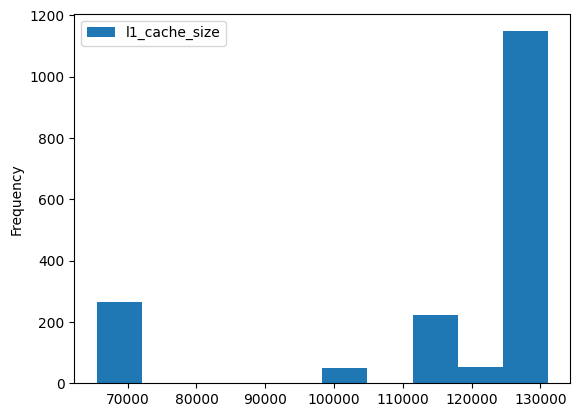

In [860]:
df_sim1.plot.hist()